<a href="https://colab.research.google.com/github/kakoli/EVA/blob/master/Session18/Assign18_FaceAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Face Alignment And Stabilization Using Dlib

In [1]:
import sys, os
IN_COLAB = 'google.colab' in sys.modules
dir = '/content/EVA-2-Group/Session-18'

if IN_COLAB:
  #import os
  os.chdir('/content')
  if not os.path.isdir('/content/EVA-2-Group/'):
    !git clone https://github.com/sambitdash/EVA-2-Group.git
  os.chdir(dir)
  !pwd  

Cloning into 'EVA-2-Group'...
remote: Enumerating objects: 1167, done.
remote: Counting objects: 100% (1167/1167), done.
remote: Compressing objects: 100% (1143/1143), done.
remote: Total 2263 (delta 44), reused 1119 (delta 15), pack-reused 1096
Receiving objects: 100% (2263/2263), 593.49 MiB | 33.04 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Checking out files: 100% (2039/2039), done.
/content/EVA-2-Group/Session-18


In [2]:
# models/*.dat are pre-trained landmark detector files
!rm -rf results
!rm -rf StitchedImages
!ls -al


total 4272
drwxr-xr-x 5 root root    4096 Dec  9 16:16 .
drwxr-xr-x 9 root root    4096 Dec  9 16:15 ..
-rw-r--r-- 1 root root  712296 Dec  9 16:15 Assignment_18.ipynb
-rw-r--r-- 1 root root    9630 Dec  9 16:15 faceBlendCommon.py
-rw-r--r-- 1 root root     772 Dec  9 16:15 file_paths.txt
drwxr-xr-x 2 root root    4096 Dec  9 16:15 images
drwxr-xr-x 2 root root    4096 Dec  9 16:15 models
-rw-r--r-- 1 root root 1115145 Dec  9 16:15 out_fps10.mp4
-rw-r--r-- 1 root root 1273393 Dec  9 16:15 out_fps15.mp4
-rw-r--r-- 1 root root 1110221 Dec  9 16:15 out_fps25.mp4
-rw-r--r-- 1 root root    1725 Dec  9 16:15 Readme.md
-rw-r--r-- 1 root root  112127 Dec  9 16:15 StitchImagesToVideo.ipynb
drwxr-xr-x 2 root root    4096 Dec  9 16:15 videos


In [0]:
import dlib
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import faceBlendCommon as fbc
%matplotlib inline

In [0]:
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

# save all images to disk
def save_all_images(path, filename, imageList):
  for cnt in range(0, len(imageList)):
    temp_fn = filename + '_' + str(cnt) + '.png'
    fn = os.path.join(path) + os.path.join(temp_fn)
    cv2.imwrite(fn, imageList[cnt])
    
# read all images
def read_all_images(dir, filename_prefix, num_files):
  result_list = []
  for cnt in range(0, num_files):
    fn = filename_prefix + '_' + str(cnt) + '.png'
    full_path = os.path.join(dir, fn)
    img = cv2.imread(full_path)
    result_list.append(img)
    
  return result_list

#### Process video into frames

In [5]:
videoFileName = "videos/NewsFeedTrim3.mp4"

# process the video frame by frame
cap = cv2.VideoCapture(videoFileName)

all_frames = []
while(cap.isOpened()):
    ret, frame = cap.read()

    if frame is None:
      break

    all_frames.append(frame)
    #plt.imshow(frame)

cap.release()
print("Video frames", len(all_frames) )
all_frames[0].shape

Video frames 153


(540, 960, 3)

Displaying first and last frames

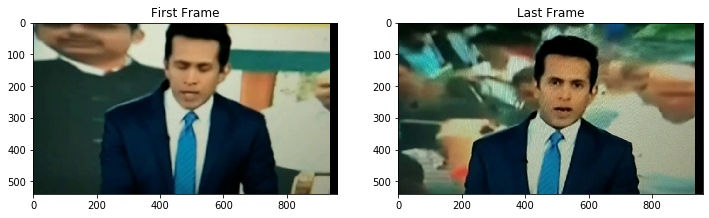

In [6]:
fig = plt.figure(figsize=(12, 5)) # width,height  
       
# Plot one original and aligned image
sub = fig.add_subplot(1, 2, 1) # nrows, ncols, index
sub.set_title("First Frame")
sub.imshow(all_frames[0][:,:,::-1])

sub = fig.add_subplot(1, 2, 2) # nrows, ncols, index
sub.set_title("Last Frame")
sub.imshow(all_frames[len(all_frames)-1][:,:,::-1])

In [7]:
if not os.path.isdir('results'):
  os.mkdir('results')
  
if not os.path.isdir('results/original'):
  os.mkdir('results/original')
  
save_all_images('results/original/', 'frame', all_frames)
!ls -al results/

total 12
drwxr-xr-x 3 root root 4096 Dec  9 16:17 .
drwxr-xr-x 7 root root 4096 Dec  9 16:17 ..
drwxr-xr-x 2 root root 4096 Dec  9 16:17 original


#### Align Faces Using 5 Point Landmark Detector

Get the model for 5 point landmark detector

In [8]:
# Landmark model location
! ls -al models
MODEL_PATH = 'models/'
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_5_face_landmarks.dat"

# Get the face detector
faceDetector = dlib.get_frontal_face_detector()

# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

total 106308
drwxr-xr-x 2 root root     4096 Dec  9 16:15 .
drwxr-xr-x 7 root root     4096 Dec  9 16:17 ..
-rw-r--r-- 1 root root  9150489 Dec  9 16:15 shape_predictor_5_face_landmarks.dat
-rw-r--r-- 1 root root 99693937 Dec  9 16:15 shape_predictor_68_face_landmarks.dat


### **Align Faces using 5-pt model**

In [0]:
# get the aligned face
def get_aligned_face(im):
  # Detect faces in the image, without upscaling
  faceRects = faceDetector(im, 0)
  #print("Number of faces detected: ",len(faceRects))

  # Detect landmarks.
  points = fbc.getLandmarks(faceDetector, landmarkDetector, im)
  #print("Points ", len(points))

  points = np.array(points)
  # Convert image to floating point in the range 0 to 1
  im = np.float32(im)/255.0

  # Dimensions of output image
  height = width = 600
  
  # Function call for alignment - normalize image to standard size, here (600, 600)
  imNorm, points = fbc.normalizeImagesAndLandmarks((height, width), im, points)

  imNorm = np.uint8(imNorm*255)
  return imNorm

In [10]:
# Get aligned faces for all frames.
all_aligned_faces = []

print('Aligning all frames... ')
# process one frame at a time. 
for cnt in range(0, len(all_frames)):
  frame = all_frames[cnt]
  aligned_face = get_aligned_face(frame)
  all_aligned_faces.append(aligned_face)

print('Done!')

Aligning all frames... 
Done!


#### Displaying original and its aligned version

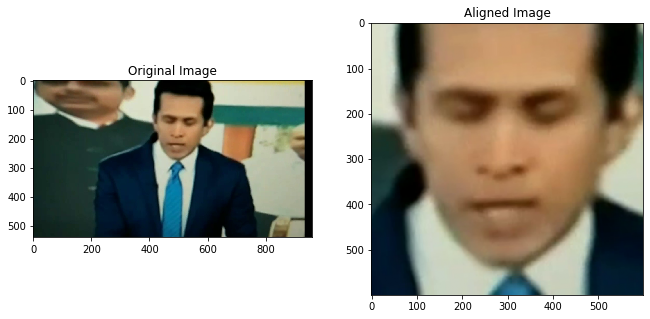

In [11]:
fig = plt.figure(figsize=(11, 5)) # width,height  
       
sub = fig.add_subplot(1, 2, 1) # nrows, ncols, index
sub.set_title("Original Image")
sub.imshow(all_frames[0][:,:,::-1])

sub = fig.add_subplot(1, 2, 2) # nrows, ncols, index
sub.set_title("Aligned Image")
sub.imshow(all_aligned_faces[0][:,:,::-1])

In [12]:
if not os.path.isdir('results/align_faces'):
  os.mkdir('results/align_faces')

save_all_images('results/align_faces/', 'align_face', all_aligned_faces)
!ls -al results/

total 24
drwxr-xr-x 4 root root  4096 Dec  9 16:19 .
drwxr-xr-x 7 root root  4096 Dec  9 16:17 ..
drwxr-xr-x 2 root root 12288 Dec  9 16:19 align_faces
drwxr-xr-x 2 root root  4096 Dec  9 16:17 original


### **Stabilize Landmarks Points in video**
Calculate the 68 point landmark on Aligned Face.

In [0]:
MODEL_PATH = 'models/'
PREDICTOR_PATH_68 = MODEL_PATH + "shape_predictor_68_face_landmarks.dat"
RESIZE_HEIGHT = 480
NUM_FRAMES_FOR_FPS = 100
SKIP_FRAMES = 1

# Function to calculate the intereye distance.
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

#### Parameters for Lucas Kanade Method

In [0]:
import math
from google.colab.patches import cv2_imshow

winSize = 101
maxLevel = 10
fps = 30.0
winName = "Stabilized facial landmark detector"

In [15]:
# Initializing video capture object.
cap = cv2.VideoCapture(videoFileName)
if(cap.isOpened()==False):
  print("Unable to load video")
  
# Grab a frame
ret, imPrev = cap.read()

# Finding the size of the image.
size = imPrev.shape[0]
print("Image size", imPrev.shape)

Image size (540, 960, 3)


In [0]:
# Initialize the face detector
detector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH_68)

# Initializing the parameters
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]
all_stabilized_frames = []

eyeDistanceNotCalculated = True
eyeDistance = 0
isFirstFrame = True
# Initial value, actual value calculated after 100 frames
fps = 10
showStabilized = False
count = 0

In [17]:
while(True):
  if (count == 0):
    t = cv2.getTickCount()
  # Grab a frame
  ret, im = cap.read()
  if im is None:
    print("Stabilisation done")
    break
    
  imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # Converting to grayscale
  imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  imGrayPrev = imGray
  height = im.shape[0]
  IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
  
  # Resize image for faster face detection
  imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
  imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
  
  # Run face detection for every image
  # Skipping the frames for faster processing
  if (count % SKIP_FRAMES == 0):
    faces = detector(imSmallDlib, 0)

  # If no face was detected
  if len(faces)==0:
    print("No face detected")

  else:
    # Loop over all detected face rectangles
    for i in range(0, len(faces)):
      #print("Face detected for frame", count)
      
      # Face detector was found over a smaller image.
      # So, we scale face rectangle to correct size.
      newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
        int(faces[i].top() * IMAGE_RESIZE),
        int(faces[i].right() * IMAGE_RESIZE),
        int(faces[i].bottom() * IMAGE_RESIZE))
      
      # Detect landmarks for every face rectangle
      landmarks = landmarkDetector(imDlib, newRect).parts()
      
      # Handling the first frame of video differently,for the first frame copy the current frame points      
      if (isFirstFrame==True):
        pointsPrev=[]
        pointsDetectedPrev = []
        [pointsPrev.append((p.x, p.y)) for p in landmarks]
        [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]

      # If not the first frame, copy points from previous frame.
      else:
        pointsPrev=[]
        pointsDetectedPrev = []
        pointsPrev = points
        pointsDetectedPrev = pointsDetectedCur

      # pointsDetectedCur stores results returned by the facial landmark detector
      # points stores the stabilized landmark points
      points = []
      pointsDetectedCur = []
      [points.append((p.x, p.y)) for p in landmarks]
      [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

      # Convert to numpy float array
      pointsArr = np.array(points,np.float32)
      pointsPrevArr = np.array(pointsPrev,np.float32)

      # If eye distance is not calculated before
      if eyeDistanceNotCalculated:
        eyeDistance = interEyeDistance(landmarks)        
        eyeDistanceNotCalculated = False
      
      # eyeDistance = 91
      if eyeDistance > 100:
        dotRadius = 4
      else:
        dotRadius = 3
      
      # sigma is to normalise distance between location of point in current and previous frame
      sigma = eyeDistance * eyeDistance / 400
      s = 2*int(eyeDistance/4)+1

      #  Set up optical flow params
      lk_params = dict(winSize = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
      
      pointsArr, status, err = cv2.calcOpticalFlowPyrLK(imGrayPrev, imGray, pointsPrevArr, pointsArr, **lk_params)      

      # Converting to float
      pointsArrFloat = np.array(pointsArr,np.float32)

      # Converting back to list
      points = pointsArrFloat.tolist()

      # Final landmark points are a weighted average of detected landmarks and tracked landmarks
      for k in range(0, len(landmarks)):
        d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
        alpha = math.exp(-d*d/sigma)
        points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

      # Drawing over the stabilized landmark points
      if showStabilized is True:
        print("True")
        for p in points:
          cv2.circle(im, (int(p[0]),int(p[1])), dotRadius, (255,0,0), -1)
      else:
        for p in pointsDetectedCur:
          cv2.circle(im, (int(p[0]),int(p[1])), dotRadius, (0,0,255), -1)  #BGR

      isFirstFrame = False
      count = count+1

      # Calculating the fps value
      if (count == NUM_FRAMES_FOR_FPS):
        # execution time in sec.
        t = (cv2.getTickCount()-t)/cv2.getTickFrequency()
        fps = NUM_FRAMES_FOR_FPS/t
        count = 0
        isFirstFrame = True

      # Display the landmarks points
      cv2.putText(im, "{:.1f}-fps".format(fps), (50, size-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)
      all_stabilized_frames.append(im)

      # Getting ready for next frame
      imPrev = im
      imGrayPrev = imGray

#cv2.destroyAllwindows()
cap.release()

Stabilisation done


#### Displaying one original and its stabilised image

152


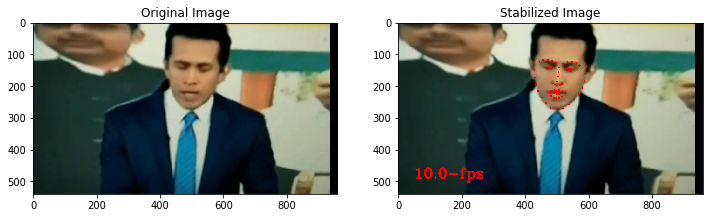

In [18]:
print(len(all_stabilized_frames))

# There is no previous info for the first frame.
# Inorder to make video, we want to have the total number of frames equal.
# so, just insert the first stabilized video frame as zeroth entry as well.
all_stabilized_frames.insert(0, all_stabilized_frames[0])
len(all_stabilized_frames)

fig = plt.figure(figsize=(12, 5)) # width,height  
       
sub = fig.add_subplot(1, 2, 1) # nrows, ncols, index starts from 1
sub.set_title("Original Image")
sub.imshow(all_frames[0][:,:,::-1])

sub = fig.add_subplot(1, 2, 2) # nrows, ncols, index
sub.set_title("Stabilized Image")
sub.imshow(all_stabilized_frames[0][:,:,::-1])

plt.show()

In [19]:
if not os.path.isdir('results/stab_frames'):
  os.mkdir('results/stab_frames')
save_all_images('results/stab_frames/', 'stab_frame', all_stabilized_frames)

!ls -al results/

total 36
drwxr-xr-x 5 root root  4096 Dec  9 16:21 .
drwxr-xr-x 7 root root  4096 Dec  9 16:17 ..
drwxr-xr-x 2 root root 12288 Dec  9 16:19 align_faces
drwxr-xr-x 2 root root  4096 Dec  9 16:17 original
drwxr-xr-x 2 root root 12288 Dec  9 16:21 stab_frames


#### Stitch Images to Video Using OpenCV

In [20]:
original_frames = read_all_images(dir + '/results/original', 'frame', 153)
aligned_frames = read_all_images(dir + '/results/align_faces', 'align_face', 153)
stabilized_frames = read_all_images(dir + '/results/stab_frames', 'stab_frame', 153)

print(original_frames[0].shape)
print(aligned_frames[0].shape)
print(stabilized_frames[0].shape)

(540, 960, 3)
(600, 600, 3)
(540, 960, 3)


Resize images

In [0]:
def resize_images(imageList, width, height):
  result_list = []
  for cnt in range(0, len(imageList)):
    new_img = cv2.resize(imageList[cnt], (width, height), interpolation=cv2.INTER_AREA)
    result_list.append(new_img)
  return result_list

In [0]:
height = width = 600
orig_frames_resized = resize_images(original_frames, width, height)
stab_frames_resized = resize_images(stabilized_frames, width, height)

#### Stitch images

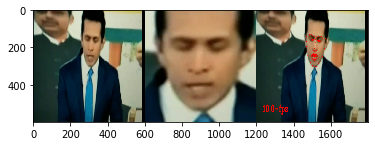

In [23]:
stitched_frames = []

for cnt in range(0, len(orig_frames_resized)):
  new_img = np.hstack((orig_frames_resized[cnt], aligned_frames[cnt], stab_frames_resized[cnt]))
  stitched_frames.append(new_img)
  
plt.imshow(stitched_frames[0][:,:,::-1])

In [24]:
os.mkdir('StitchedImages')
print("Stitched image size", stitched_frames[0].shape)

save_all_images('StitchedImages/', 'stitch', stitched_frames)
!ls -al

Stitched image size (600, 1800, 3)
total 4284
drwxr-xr-x 8 root root    4096 Dec  9 16:22 .
drwxr-xr-x 9 root root    4096 Dec  9 16:15 ..
-rw-r--r-- 1 root root  712296 Dec  9 16:15 Assignment_18.ipynb
-rw-r--r-- 1 root root    9630 Dec  9 16:15 faceBlendCommon.py
-rw-r--r-- 1 root root     772 Dec  9 16:15 file_paths.txt
drwxr-xr-x 2 root root    4096 Dec  9 16:15 images
drwxr-xr-x 2 root root    4096 Dec  9 16:15 models
-rw-r--r-- 1 root root 1115145 Dec  9 16:15 out_fps10.mp4
-rw-r--r-- 1 root root 1273393 Dec  9 16:15 out_fps15.mp4
-rw-r--r-- 1 root root 1110221 Dec  9 16:15 out_fps25.mp4
drwxr-xr-x 2 root root    4096 Dec  9 16:16 __pycache__
-rw-r--r-- 1 root root    1725 Dec  9 16:15 Readme.md
drwxr-xr-x 5 root root    4096 Dec  9 16:21 results
drwxr-xr-x 2 root root    4096 Dec  9 16:22 StitchedImages
-rw-r--r-- 1 root root  112127 Dec  9 16:15 StitchImagesToVideo.ipynb
drwxr-xr-x 2 root root    4096 Dec  9 16:15 videos


#### Create Video

In [26]:
!pip install ffmpeg

  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp36-none-any.whl size=6085 sha256=890f4178f87dea5581dbb27686b87ae9fbae0cd2f70d2925482ffec45a6a689a
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


In [27]:
#!ffmpeg -h
!ffmpeg -y -r 10 -f concat -safe 0 -i "./file_paths.txt" "outNew_fps10.mp4"

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [31]:
from google.colab import drive

drive.mount('/content/gdrive')
#dir="/content/gdrive/My Drive/Colab Notebooks/Weights/EVA/"
!pwd
!ls -al

!cp /content/EVA-2-Group/Session-18/outNew_fps10.mp4 "/content/gdrive/My Drive/Colab Notebooks/EVA/Session11_20/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/EVA-2-Group/Session-18


In [0]:
# !git config user.email "sambitdash@gmail.com"
# !git config user.name "Sambit Kumar Dash"
# !git config user.password "your password"
# !git status
# !git commit -a -m "GitHub compliant changes"